# Preprocessed Videos EDA [v3]

### Contents

- Check the landmark extremes
- Explore the none frames
- Checking some things are consistent before and after preprocessing
- Explore the none frames

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import seaborn as sns
import vizualisation as viz
import video_analyzer as va
import shutil

2025-05-03 20:23:40.124134: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746271420.319367   48050 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746271420.375307   48050 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-03 20:23:40.890619: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
path_to_root = '/home/ben/projects/SaoPauloBrazilChapter_BrazilianSignLanguage/'

In [4]:
timestamp = "04242025"
motion_version = "versionB"
pose_version = "versionB"
preprocess_version = "v3"

In [5]:
metadata = pd.read_csv(path_to_root + '/data/preprocessed/landmarks_metadata_'+preprocess_version+'.csv')

In [ ]:
i = 0
metadata_row = metadata.iloc[i].copy()
raw_landmarks_path = path_to_root + f'/data/interim/RawPoseLandmarks/{pose_version}/{metadata_row["filename"].replace(".mp4", ".npy")}'
preprocessed_landmarks_path = path_to_root + f'/data/preprocessed/landmarks/{preprocess_version}/{metadata_row["filename"].replace(".mp4", ".npy")}'
video_path = path_to_root + f'/data/interim/RawCleanVideos/{metadata_row["filename"]}'
raw_landmarks = np.load(raw_landmarks_path, allow_pickle=True)
preprocessed_landmarks = np.load(preprocessed_landmarks_path, allow_pickle=True)
metadata_row

filename                             ajudar_ne_1.mp4
label                                         ajudar
data_source                                       ne
original_fps                                    12.0
original_frame_count                              44
original_duration_sec                       3.666667
start_frame                                        7
end_frame                                         36
processed_frame_count                             30
processed_duration_sec                           2.5
preprocess_version                                v3
face_width                                  0.147576
shoulders_width                             0.333421
face_midpoint_to_shoulders_height           0.292776
left_hand_interpolated_frames                      0
right_hand_interpolated_frames                     1
original_left_hand_none_frames                     0
original_right_hand_none_frames                    1
final_left_hand_none_frames                   

## Full Dataset Analysis Info

Load all the analysis info .jsons for the full dataset and combine into a dataframe

In [17]:
p_metadata = pd.read_csv(path_to_root + "data/preprocessed/landmarks_metadata_v3.csv")
p_metadata.head()

,filename,label,data_source,original_fps,original_frame_count,original_duration_sec,start_frame,end_frame,processed_frame_count,processed_duration_sec,preprocess_version,face_width,shoulders_width,face_midpoint_to_shoulders_height,left_hand_interpolated_frames,right_hand_interpolated_frames,original_left_hand_none_frames,original_right_hand_none_frames,final_left_hand_none_frames,final_right_hand_none_frames
0,ajudar_ne_1.mp4,ajudar,ne,12.00000,44,3.666667,7,36,30,2.500000,v3,0.147576,0.333421,0.292776,0,1,0,1,0,0
1,ajudar_sb_2.mp4,ajudar,sb,29.97003,79,2.635967,6,66,61,2.035367,v3,0.086359,0.206200,0.216821,0,0,0,0,0,0
2,ajudar_uf_3.mp4,ajudar,uf,29.97003,115,3.837167,24,89,66,2.202200,v3,0.090604,0.205890,0.222293,0,0,0,0,0,0
3,ajudar_vl_4.mp4,ajudar,vl,29.97003,141,4.704700,11,126,116,3.870533,v3,0.100236,0.210215,0.240169,7,7,25,8,18,0
4,ajudar_vl_5.mp4,ajudar,vl,29.97000,108,3.603604,0,106,107,3.570237,v3,0.114839,0.243479,0.246769,0,2,13,12,13,10


In [18]:
p_metadata.columns

Index(['filename', 'label', 'data_source', 'original_fps',
       'original_frame_count', 'original_duration_sec', 'start_frame',
       'end_frame', 'processed_frame_count', 'processed_duration_sec',
       'preprocess_version', 'face_width', 'shoulders_width',
       'face_midpoint_to_shoulders_height', 'left_hand_interpolated_frames',
       'right_hand_interpolated_frames', 'original_left_hand_none_frames',
       'original_right_hand_none_frames', 'final_left_hand_none_frames',
       'final_right_hand_none_frames'],
      dtype='object')

In [19]:
def nested_dict_to_df(nested_dict, prefix=''):
    flat_dict = {}
    
    def flatten(d, parent_key=''):
        for key, value in d.items():
            new_key = f"{parent_key}_{key}" if parent_key else key
            
            if isinstance(value, dict):
                flatten(value, new_key)
            else:
                flat_dict[new_key] = value
    
    flatten(nested_dict)
    return pd.DataFrame([flat_dict])

In [20]:
analysis_info_list = []

for i, row in metadata.iterrows():
    fn = row["filename"]
    analysis_info_path = os.path.join(
        path_to_root, 
        "data", 
        "preprocessed", 
        "landmarks",
        preprocess_version,
        "individual_metadata",
        fn.replace("mp4", "json")
    )
    if os.path.exists(analysis_info_path):
        with open(analysis_info_path, "r") as f:
            analysis_info_dict = json.load(f)
    analysis_info_df = nested_dict_to_df(analysis_info_dict)
    analysis_info_list.append(analysis_info_df)

In [21]:
analysis_info_list[0]

,metadata_filename,metadata_label,metadata_data_source,metadata_sign_id,metadata_signer_number,metadata_frame_count,metadata_fps,metadata_duration_sec,metadata_width,metadata_height,...,landmark_none_mask_arrays_face_landmarks_interpolation_binary_array_no_trailing_values,landmark_none_mask_arrays_face_landmarks_interpolation_sequence_length_array_no_trailing_values,landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array,landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array,landmark_none_mask_arrays_left_hand_landmarks_interpolation_binary_array_no_trailing_values,landmark_none_mask_arrays_left_hand_landmarks_interpolation_sequence_length_array_no_trailing_values,landmark_none_mask_arrays_right_hand_landmarks_interpolation_binary_array,landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array,landmark_none_mask_arrays_right_hand_landmarks_interpolation_binary_array_no_trailing_values,landmark_none_mask_arrays_right_hand_landmarks_interpolation_sequence_length_array_no_trailing_values
0,ajudar_ne_1.mp4,ajudar,ne,2,1,44,12.0,3.666667,240,176,...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [22]:
analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)

/tmp/ipykernel_48050/574225212.py:1: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  analysis_info = pd.concat(analysis_info_list, axis = 0).sort_values(by = "metadata_filename", ascending = True, key = lambda x: x.str.split("_").str[0] + x.str[-5]).reset_index(drop = True)


In [23]:
analysis_info.head()

,metadata_filename,metadata_label,metadata_data_source,metadata_sign_id,metadata_signer_number,metadata_frame_count,metadata_fps,metadata_duration_sec,metadata_width,metadata_height,...,interpolated_none_analysis_right_hand_landmarks_total_frames,interpolated_none_analysis_right_hand_landmarks_none_frames,interpolated_none_analysis_right_hand_landmarks_frame_percentage,interpolated_none_analysis_right_hand_landmarks_continuous,interpolated_none_analysis_right_hand_landmarks_first_valid,interpolated_none_analysis_right_hand_landmarks_last_valid,interpolated_none_analysis_right_hand_landmarks_valid_range_total_frames,interpolated_none_analysis_right_hand_landmarks_valid_range_none_frames,interpolated_none_analysis_right_hand_landmarks_valid_range_frame_percentage,interpolated_none_analysis_right_hand_landmarks_valid_range_none_details
0,ajudar_ne_1.mp4,ajudar,ne,2,1,44,12.00000,3.666667,240,176,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ajudar_sb_2.mp4,ajudar,sb,1,1,79,29.97003,2.635967,1280,720,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ajudar_uf_3.mp4,ajudar,uf,0,1,115,29.97003,3.837167,480,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ajudar_vl_4.mp4,ajudar,vl,0,1,141,29.97003,4.704700,1920,1080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ajudar_vl_5.mp4,ajudar,vl,0,2,108,29.97000,3.603604,1920,1080,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Example Videos

In [15]:
analysis_info[(analysis_info['trimmed_none_analysis_overall_none_landmark_frames'] ==0)].metadata_data_source.value_counts()

metadata_data_source
sb    8
uf    8
vl    7
Name: count, dtype: int64

In [21]:
data_sources = []
labels = []
frame_lists = []
for i, row in analysis_info.sort_values(by = 'trimmed_none_analysis_overall_none_landmark_frames').iterrows():
    label = row['metadata_label']
    data_source = row['metadata_data_source']
    fps = row['metadata_fps']
    if label in labels:
        continue
    if data_source in data_sources:
        continue
    data_sources.append(data_source)
    labels.append(label)
    print(label, row.trimmed_reference_points_total_frames_used)

    demo_app_dir = path_to_root + f'/data/Demo App (Development)/'
    demo_app_raw_video_dir = demo_app_dir + 'Example Raw Videos/'
    demo_app_skeleton_dir = demo_app_dir + 'Example Skeleton Videos/'

    raw_video_path = path_to_root + f'/data/interim/RawCleanVideos/{row["metadata_filename"]}'
    shutil.copy(raw_video_path, demo_app_raw_video_dir + row['metadata_filename'])
    
    landmarks_path = path_to_root + f'/data/preprocessed/landmarks/{preprocess_version}/{row["metadata_filename"].replace(".mp4", ".npy")}'
    landmarks = np.load(landmarks_path, allow_pickle=True)
    skeleton_video_path = demo_app_skeleton_dir + row['metadata_filename']
    frame_list = viz.draw_landmarks_on_video_with_frame(results_list = landmarks, output_path = skeleton_video_path, fps = fps)
    frame_lists.append(frame_list)

    if sorted(data_sources) == ['ne', 'sb', 'uf', 'vl']:
        print(f"Found all data sources: {data_sources}")
        break

comer 56


casa 155
cabeça 65
ajudar 30
Found all data sources: ['uf', 'vl', 'sb', 'ne']


## Check the logic of the preprocessing

### Offsets
After alignment, the offsets should be close to 0.

#### X

Text(0.5, 1.02, 'Horizontal Offsets at different stages of preprocessing')

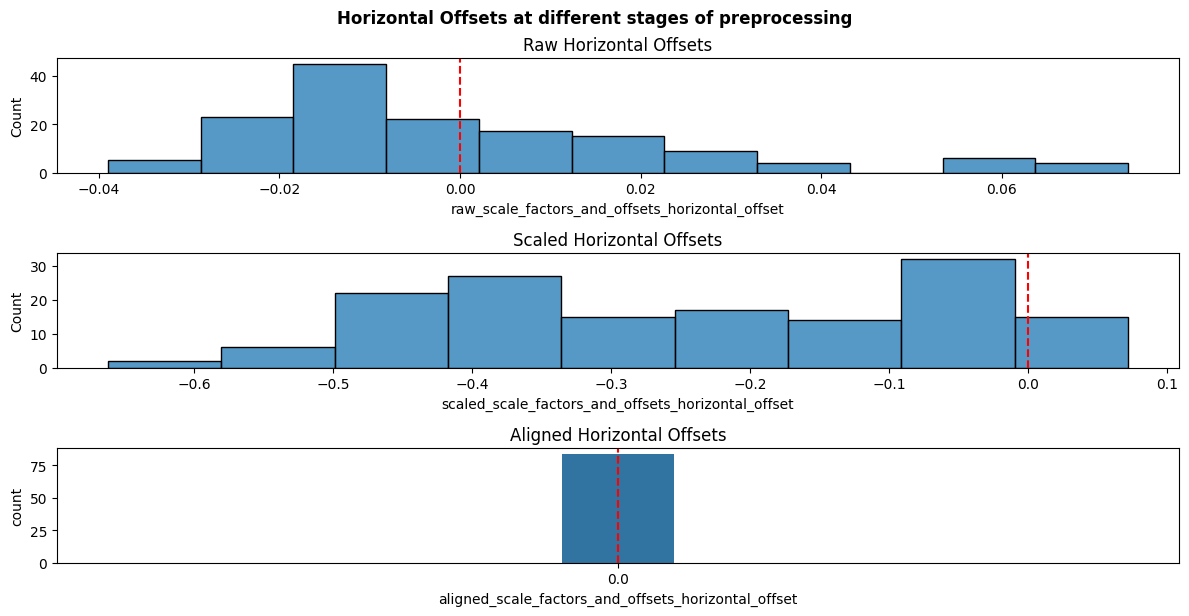

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

sns.histplot(data=analysis_info, x='raw_scale_factors_and_offsets_horizontal_offset', ax=ax1)
ax1.set_title('Raw Horizontal Offsets')
# ax1.set_xlim(-0.05, 0.05)
ax1.axvline(x=0, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='scaled_scale_factors_and_offsets_horizontal_offset', ax=ax2) 
ax2.set_title('Scaled Horizontal Offsets')
# ax2.set_xlim(-.8, 0.2)
ax2.axvline(x=0, color='red', linestyle='--')

sns.countplot(data=analysis_info, x='aligned_scale_factors_and_offsets_horizontal_offset', ax=ax3, width=0.01)
ax3.set_title('Aligned Horizontal Offsets')
ax3.set_xlim(-0.05, 0.05)
ax3.axvline(x=0, color='red', linestyle='--')
plt.tight_layout()
plt.suptitle("Horizontal Offsets at different stages of preprocessing", fontweight = "bold", y = 1.02)

#### Y

Text(0.5, 1.02, 'Vertical Offsets at different stages of preprocessing')

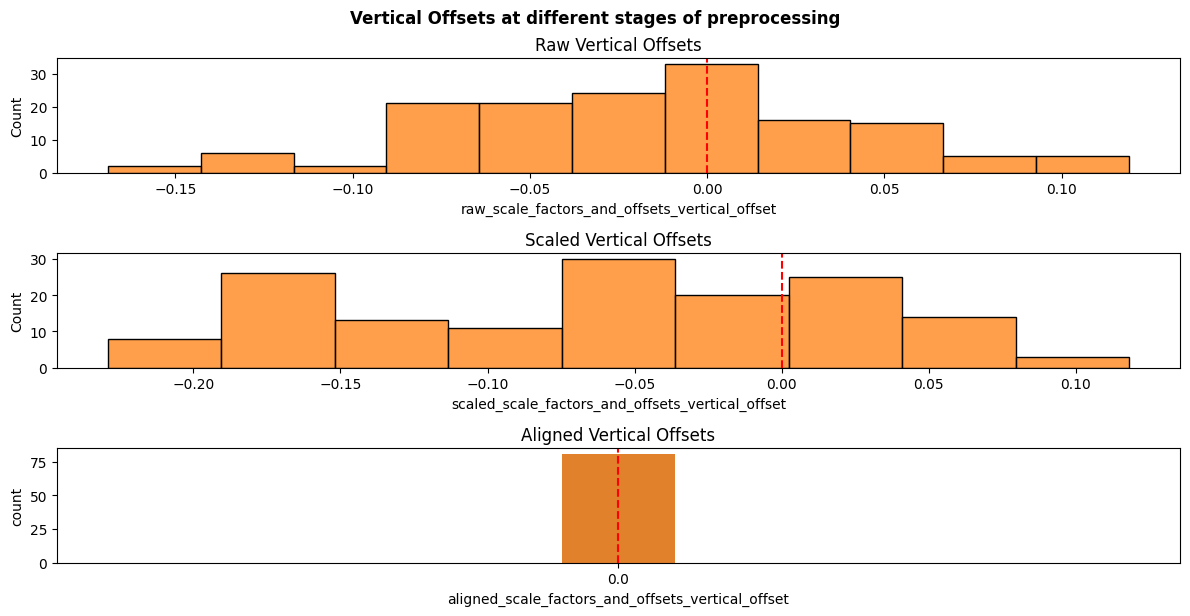

In [17]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 6))

sns.histplot(data=analysis_info, x='raw_scale_factors_and_offsets_vertical_offset', ax=ax1, color = "tab:orange")
ax1.set_title('Raw Vertical Offsets')
# ax1.set_xlim(-0.05, 0.05)
ax1.axvline(x=0, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='scaled_scale_factors_and_offsets_vertical_offset', ax=ax2, color = "tab:orange")
ax2.set_title('Scaled Vertical Offsets')
# ax2.set_xlim(-.8, 0.2)
ax2.axvline(x=0, color='red', linestyle='--')

sns.countplot(data=analysis_info, x='aligned_scale_factors_and_offsets_vertical_offset', ax=ax3, width=0.01, color = "tab:orange")
ax3.set_title('Aligned Vertical Offsets')
ax3.set_xlim(-0.05, 0.05)
ax3.axvline(x=0, color='red', linestyle='--')

plt.tight_layout()
plt.suptitle("Vertical Offsets at different stages of preprocessing", fontweight = "bold", y = 1.02)

### Scale Factors

Text(0.5, 1.02, 'Scale Factors at different stages of preprocessing')

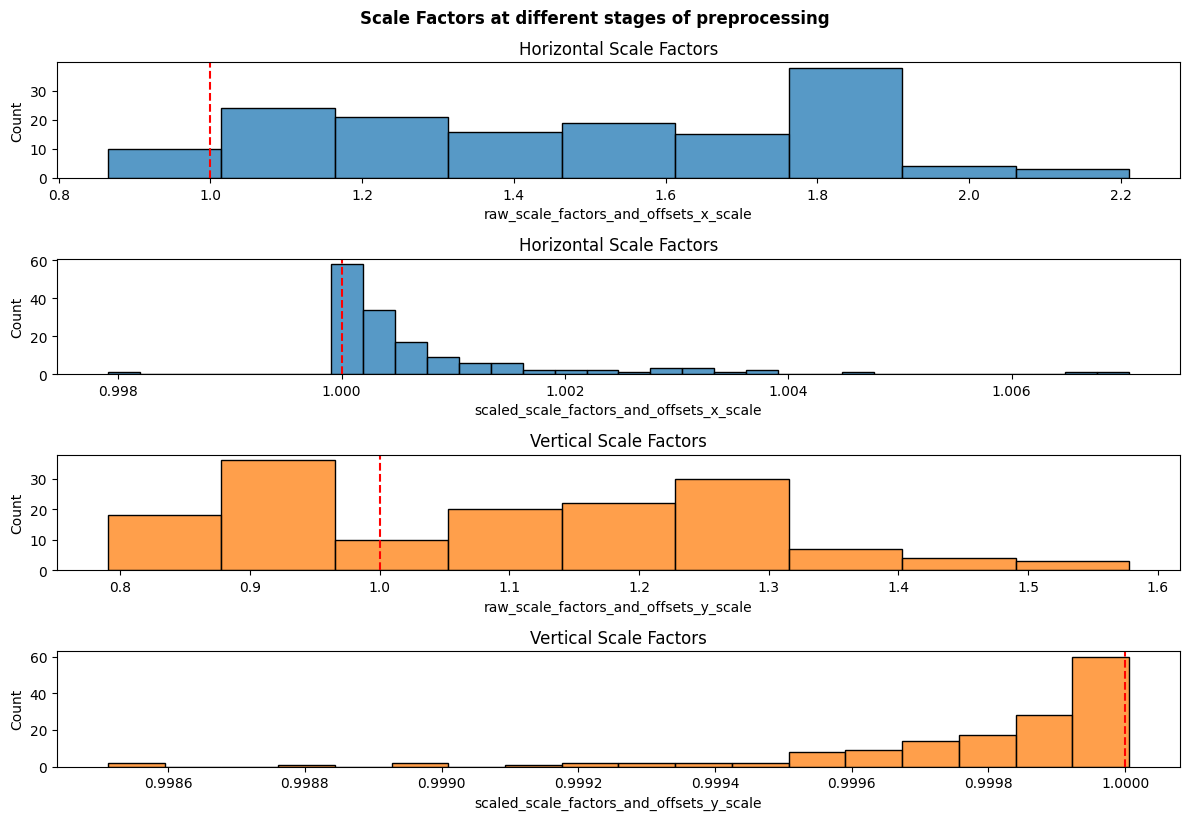

In [18]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

sns.histplot(data=analysis_info, x='raw_scale_factors_and_offsets_x_scale', ax=ax1, color = "tab:blue")
ax1.set_title('Horizontal Scale Factors')
ax1.axvline(x=1, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='scaled_scale_factors_and_offsets_x_scale', ax=ax2, color = "tab:blue")
ax2.set_title('Horizontal Scale Factors')
ax2.axvline(x=1, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='raw_scale_factors_and_offsets_y_scale', ax=ax3, color = "tab:orange")
ax3.set_title('Vertical Scale Factors')
ax3.axvline(x=1, color='red', linestyle='--')

sns.histplot(data=analysis_info, x='scaled_scale_factors_and_offsets_y_scale', ax=ax4, color = "tab:orange")
ax4.set_title('Vertical Scale Factors')
ax4.axvline(x=1, color='red', linestyle='--')

plt.tight_layout()
plt.suptitle("Scale Factors at different stages of preprocessing", fontweight = "bold", y = 1.02)

Text(0.5, 1.02, 'Scale Factors at different stages of preprocessing')

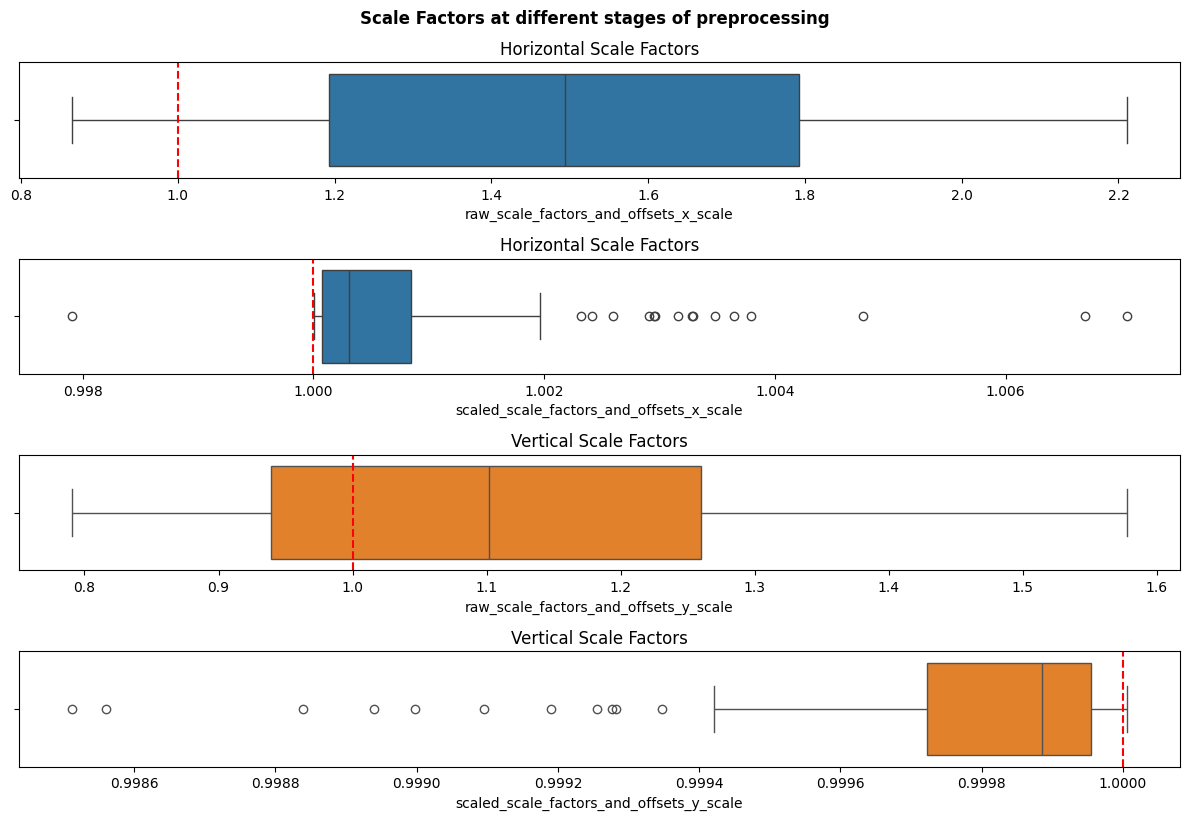

In [19]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 8))

sns.boxplot(data=analysis_info, x='raw_scale_factors_and_offsets_x_scale', ax=ax1, color = "tab:blue")
ax1.set_title('Horizontal Scale Factors')
ax1.axvline(x=1, color='red', linestyle='--')

sns.boxplot(data=analysis_info, x='scaled_scale_factors_and_offsets_x_scale', ax=ax2, color = "tab:blue")
ax2.set_title('Horizontal Scale Factors')
ax2.axvline(x=1, color='red', linestyle='--')

sns.boxplot(data=analysis_info, x='raw_scale_factors_and_offsets_y_scale', ax=ax3, color = "tab:orange")
ax3.set_title('Vertical Scale Factors')
ax3.axvline(x=1, color='red', linestyle='--')

sns.boxplot(data=analysis_info, x='scaled_scale_factors_and_offsets_y_scale', ax=ax4, color = "tab:orange")
ax4.set_title('Vertical Scale Factors')
ax4.axvline(x=1, color='red', linestyle='--')

plt.tight_layout()
plt.suptitle("Scale Factors at different stages of preprocessing", fontweight = "bold", y = 1.02)

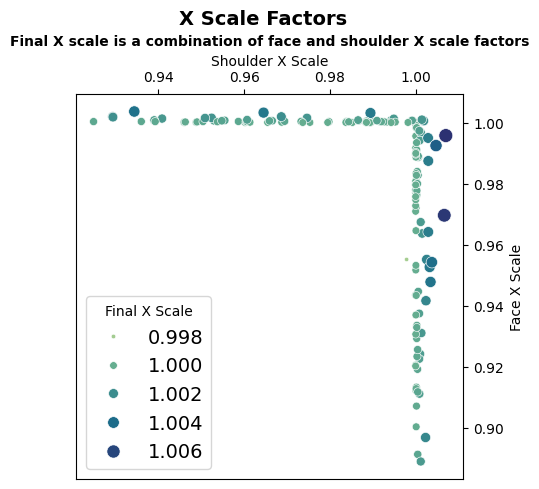

In [20]:
# plot scaled_scale_factors_and_offsets_x_scale against scaled_scale_factors_and_offsets_face_x_scale & scaled_scale_factors_and_offsets_shoulders_x_scale
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=analysis_info, 
    x='scaled_scale_factors_and_offsets_shoulders_x_scale', 
    y='scaled_scale_factors_and_offsets_face_x_scale',
    hue = 'scaled_scale_factors_and_offsets_x_scale',
    palette = "crest",
    size = 'scaled_scale_factors_and_offsets_x_scale',
    sizes = (10, 100),
    )
plt.suptitle("X Scale Factors", y = 1.05, fontweight = "bold", fontsize = 14)
plt.title("Final X scale is a combination of face and shoulder X scale factors", fontweight = "bold", fontsize = 10)
plt.xlabel("Shoulder X Scale")
plt.ylabel("Face X Scale")
plt.legend(title = "Final X Scale", fontsize = 14)
# Turn on the right and top spines
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)

# Move ticks to top and right
ax.xaxis.set_ticks_position('top')
ax.yaxis.set_ticks_position('right')

# Move labels to top and right
ax.xaxis.set_label_position('top')
ax.yaxis.set_label_position('right')


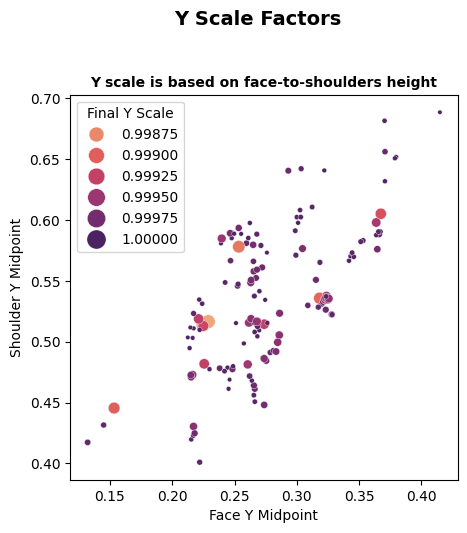

In [21]:
# plot scaled_scale_factors_and_offsets_x_scale against scaled_scale_factors_and_offsets_face_x_scale & scaled_scale_factors_and_offsets_shoulders_x_scale
fig, ax = plt.subplots(figsize=(5, 5))
sns.scatterplot(data=analysis_info, 
    x='raw_reference_points_face_midpoint_y', 
    y='raw_reference_points_shoulders_midpoint_y',
    hue = 'scaled_scale_factors_and_offsets_y_scale',
    palette = "flare",
    size = 'scaled_scale_factors_and_offsets_y_scale',
    sizes = (100, 10),
    )
plt.suptitle("Y Scale Factors", y = 1.05, fontweight = "bold", fontsize = 14)
plt.title("Y scale is based on face-to-shoulders height", fontweight = "bold", fontsize = 10)
plt.xlabel("Face Y Midpoint")
plt.ylabel("Shoulder Y Midpoint")
plt.legend(title = "Final Y Scale", fontsize = 10)
# Turn on the right and top spines
# ax.spines['right'].set_visible(True)
# ax.spines['top'].set_visible(True)

# # Move ticks to top and right
# ax.xaxis.set_ticks_position('top')
# ax.yaxis.set_ticks_position('right')

# # Move labels to top and right
# ax.xaxis.set_label_position('top')
# ax.yaxis.set_label_position('right')


### Motion Trimming

In [48]:
def get_outliers(group):
    Q1 = group.quantile(0.25)
    Q3 = group.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return group[(group < lower_bound) | (group > upper_bound)]

def get_outlier_df(df, col):
    outliers = []
    for ds, ds_info in df.groupby('metadata_data_source'):
        outlier = get_outliers(ds_info[col])
        outlier_row = df.iloc[outlier.index][['metadata_filename', 'metadata_data_source', col]]
        outliers.append(outlier_row)
    outliers_df = pd.concat(outliers)
    outliers_df['col'] = col + '_outliers'
    return outliers_df

def get_minmax_df(df, col, exclude_df):
    include_df = df[~df.index.isin(exclude_df.index)]

    min_idx = include_df.groupby('metadata_data_source')[col].idxmin()
    max_idx = include_df.groupby('metadata_data_source')[col].idxmax()

    # Get the full rows for these min/max values using concat instead of append
    # Create separate dataframes for min and max with labels
    min_rows = include_df.loc[min_idx].assign(type='min')[['metadata_filename', 'metadata_data_source', col]]
    min_rows['col'] = col + '_min'
    max_rows = include_df.loc[max_idx].assign(type='max')[['metadata_filename', 'metadata_data_source', col]]
    max_rows['col'] = col + '_max'
    # Combine them
    minmax_rows = pd.concat([min_rows, max_rows]).sort_values('metadata_data_source')
    return minmax_rows

def get_outlier_df_and_minmax_df(df, col):
    outliers_df = get_outlier_df(df, col)
    minmax_df = get_minmax_df(df, col, outliers_df)
    return outliers_df, minmax_df

#### Overall Distribution of the Motion Trimming Results

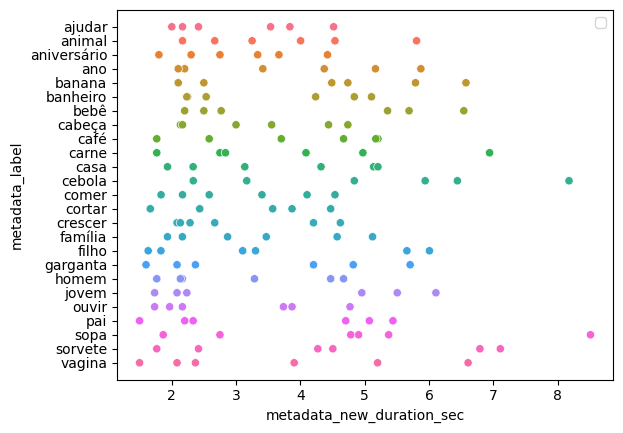

In [17]:
sns.scatterplot(data=analysis_info, x='metadata_new_duration_sec', y='metadata_label', hue='metadata_label')
plt.legend('')


<Axes: xlabel='metadata_new_duration_sec', ylabel='metadata_label'>

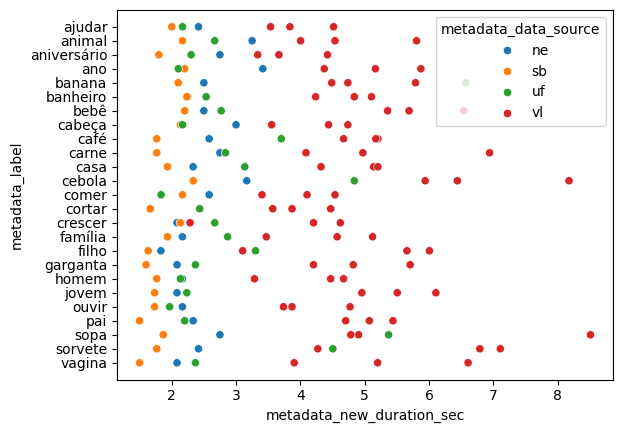

In [25]:
sns.scatterplot(data=analysis_info, x='metadata_new_duration_sec', y='metadata_label', hue='metadata_data_source')


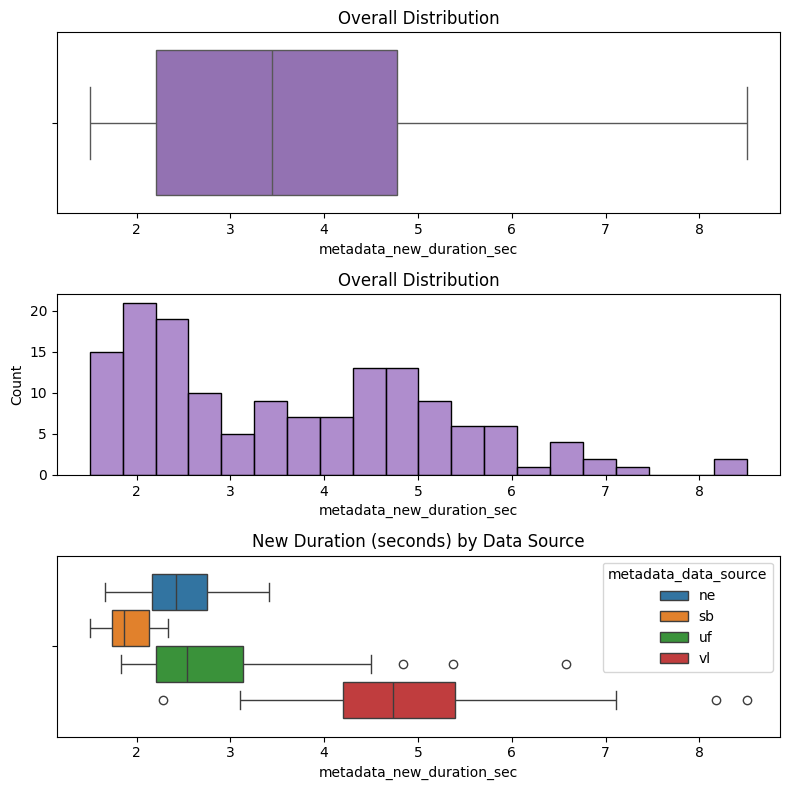

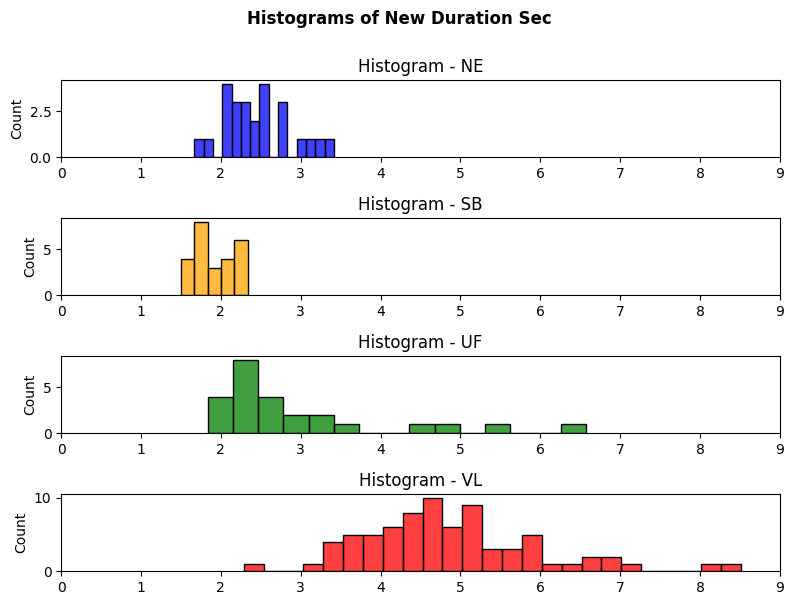

In [18]:
# boxplot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 8))

sns.boxplot(data=analysis_info, x='metadata_new_duration_sec', color="tab:purple", ax=ax1)
ax1.set_title("Overall Distribution")

sns.histplot(data=analysis_info, x='metadata_new_duration_sec', color="tab:purple", ax=ax2, bins=20)
ax2.set_title("Overall Distribution")

sns.boxplot(data=analysis_info, x='metadata_new_duration_sec', hue='metadata_data_source', ax=ax3)
ax3.set_title("Distribution by Data Source")

plt.tight_layout()
plt.title("New Duration (seconds) by Data Source")

plt.show()
# 5 subplots
fig, axs = plt.subplots(4, 1, figsize=(8, 6));
# kde plot of metadata_new_duration_sec for each data source, histogram of metadata_new_duration_sec for each data source
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'metadata_new_duration_sec', ax = axs[0], bins=15, color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'metadata_new_duration_sec', ax = axs[1], bins=5, color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'metadata_new_duration_sec', ax = axs[2], bins=15, color = 'green',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'metadata_new_duration_sec', ax = axs[3], bins=25, color = 'red',)

axs[0].set_title('Histogram - NE');
axs[1].set_title('Histogram - SB');
axs[2].set_title('Histogram - UF');
axs[3].set_title('Histogram - VL');
for ax in axs:
    ax.set_xlim(0, 9)
    ax.set_xlabel('')
    # ax.set_ylim(0,8)
plt.suptitle('Histograms of New Duration Sec', fontweight = 'bold', y = 1);
plt.tight_layout()

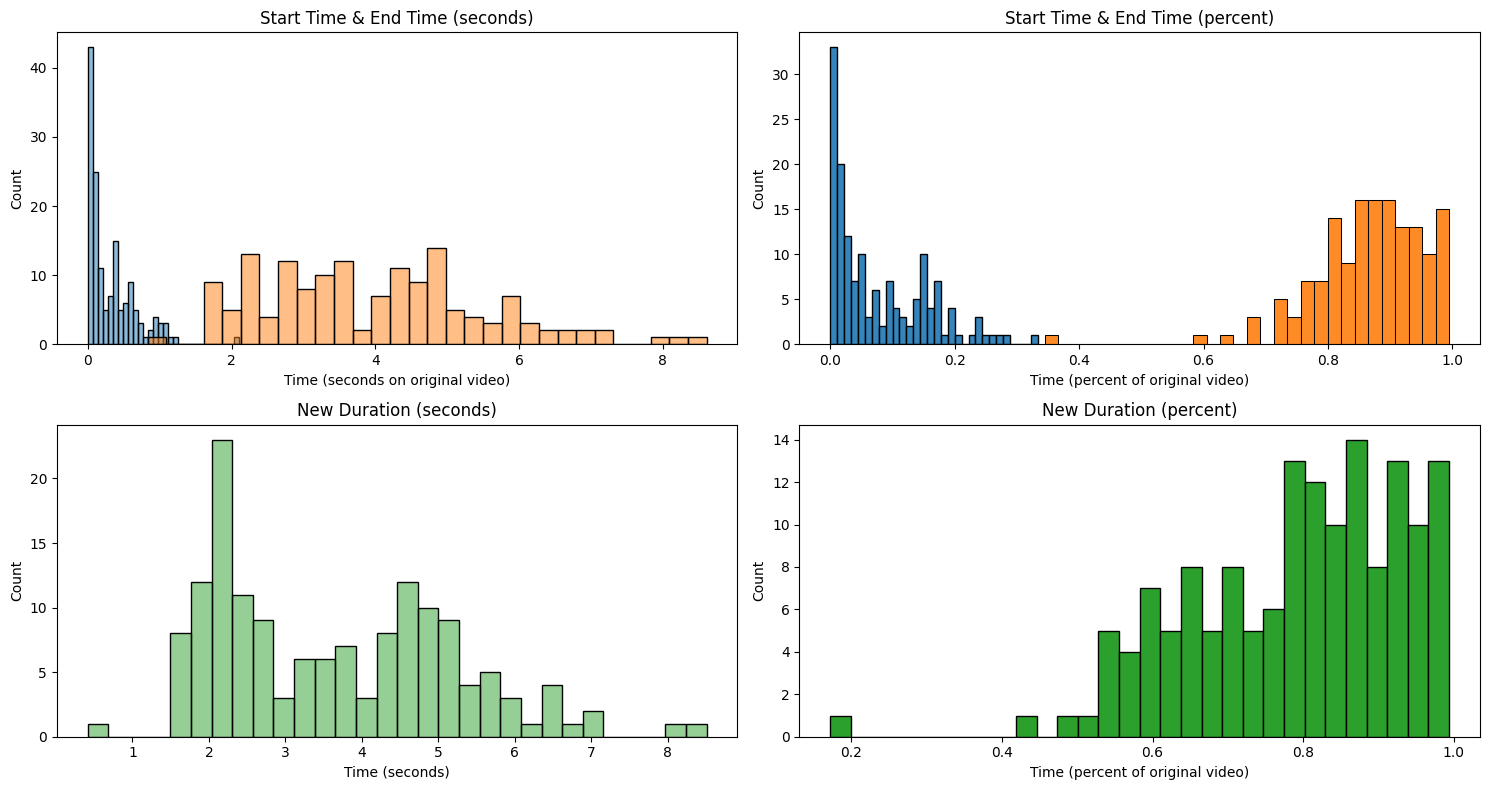

In [23]:
fig, ax = plt.subplots(2, 2, figsize=(15, 8))

sns.histplot(analysis_info.metadata_start_time, bins=30, ax=ax[0, 0], alpha = 0.5)
sns.histplot(analysis_info.metadata_end_time, bins=30, ax=ax[0, 0], alpha = 0.5)
ax[0, 0].set_title('Start Time & End Time (seconds)')
ax[0, 0].set_xlabel("Time (seconds on original video)")

sns.histplot(analysis_info.metadata_start_percent, bins=30, ax=ax[0, 1], alpha = 0.9) 
sns.histplot(analysis_info.metadata_end_percent, bins=30, ax=ax[0, 1], alpha = 0.9) 
ax[0, 1].set_title('Start Time & End Time (percent)')
ax[0, 1].set_xlabel("Time (percent of original video)")

sns.histplot(analysis_info.metadata_new_duration_sec, bins=30, ax=ax[1, 0], alpha = 0.5, color = "tab:green") 
ax[1, 0].set_title('New Duration (seconds)')
ax[1, 0].set_xlabel("Time (seconds)")
sns.histplot(analysis_info.metadata_new_duration_percent, bins=30, ax=ax[1, 1], alpha = 1, color = "tab:green") 
ax[1, 1].set_title('New Duration (percent)')   
ax[1, 1].set_xlabel("Time (percent of original video)")
plt.tight_layout()

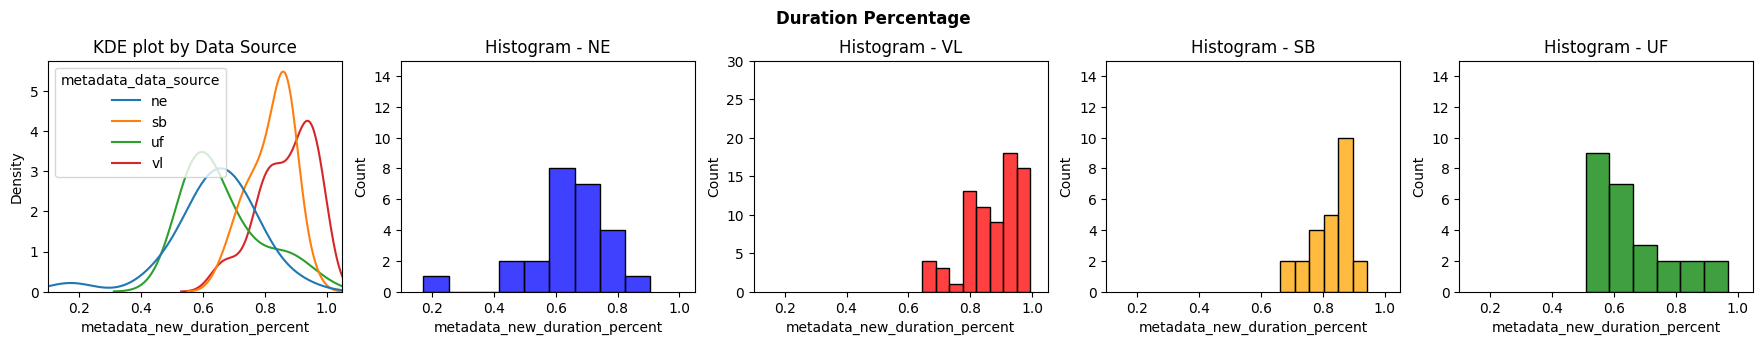

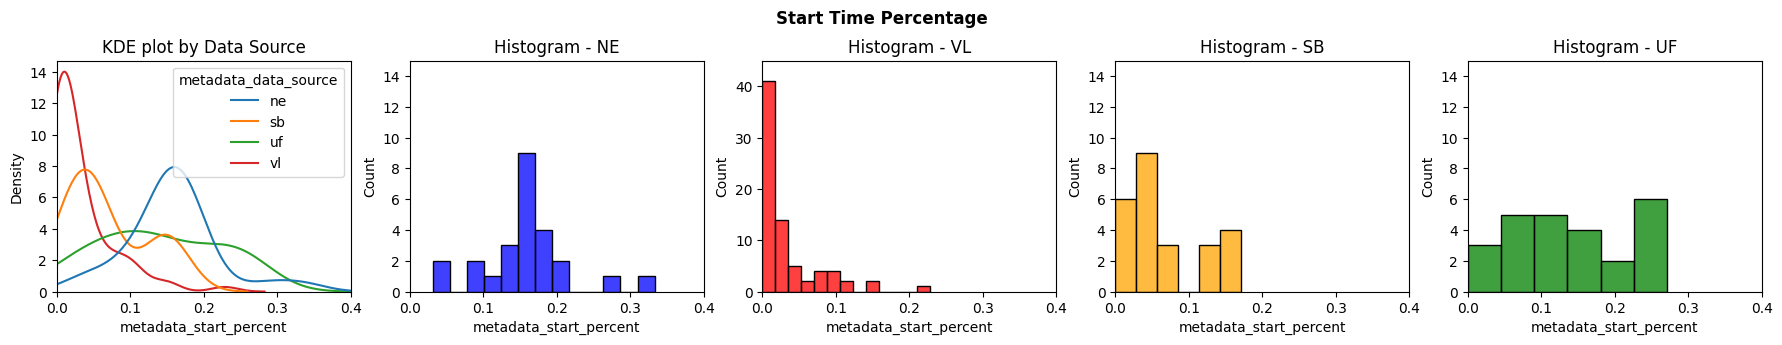

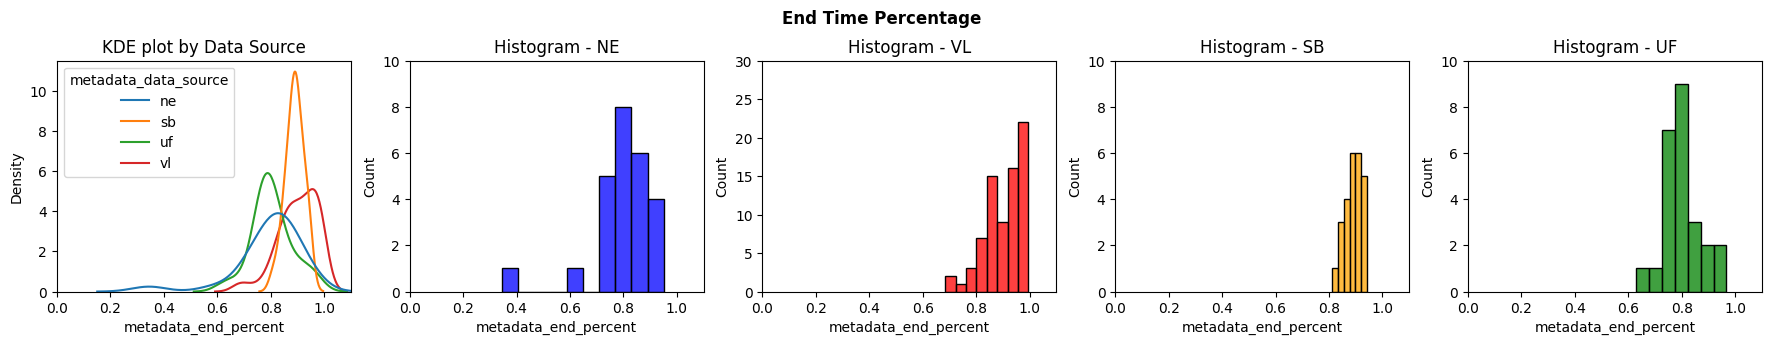

In [58]:
# 5 subplots
fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of metadata_new_duration_percent for each data source, histogram of metadata_new_duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'metadata_new_duration_percent', hue = 'metadata_data_source', ax = axs[0], common_norm=False)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'metadata_new_duration_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'metadata_new_duration_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'metadata_new_duration_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'metadata_new_duration_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0.1, 1.05)
    if i == 0:
        # ax.set_ylim(0, 5)
        pass
    elif i == 2:
        ax.set_ylim(0, 30)
    else:
        ax.set_ylim(0, 15)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('Duration Percentage', fontweight = 'bold', y = 1.05);

fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of metadata_new_duration_percent for each data source, histogram of metadata_new_duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'metadata_start_percent', hue = 'metadata_data_source', ax = axs[0], common_norm=False)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'metadata_start_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'metadata_start_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'metadata_start_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'metadata_start_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0, 0.4)
    if i == 0:
        # ax.set_ylim(0, 5)
        pass
    elif i == 2:
        ax.set_ylim(0, 45)
    else:
        ax.set_ylim(0, 15)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('Start Time Percentage', fontweight = 'bold', y = 1.05);


fig, axs = plt.subplots(1, 5, figsize=(22, 3));
# kde plot of metadata_new_duration_percent for each data source, histogram of metadata_new_duration_percent for each data source
sns.kdeplot(data = analysis_info, x = 'metadata_end_percent', hue = 'metadata_data_source', ax = axs[0], common_norm=False)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'ne'], x = 'metadata_end_percent', ax = axs[1], color = 'blue',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'vl'], x = 'metadata_end_percent', ax = axs[2], color = 'red',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'sb'], x = 'metadata_end_percent', ax = axs[3], color = 'orange',)
sns.histplot(data = analysis_info[analysis_info.metadata_data_source == 'uf'], x = 'metadata_end_percent', ax = axs[4], color = 'green',)
for i, ax in enumerate(axs):
    ax.set_xlim(0, 1.1)
    if i == 0:
        # ax.set_ylim(0, 5)
        pass
    elif i == 2:
        ax.set_ylim(0, 30)
    else:
        ax.set_ylim(0, 10)
axs[0].set_title('KDE plot by Data Source');
axs[1].set_title('Histogram - NE');
axs[2].set_title('Histogram - VL');
axs[3].set_title('Histogram - SB');
axs[4].set_title('Histogram - UF');
plt.suptitle('End Time Percentage', fontweight = 'bold', y = 1.05);

#### Checking the edge cases for issues

In [143]:
new_duration_outliers, new_duration_minmaxes = get_outlier_df_and_minmax_df(analysis_info, 'metadata_new_duration_sec')
start_percent_outliers, start_percent_minmaxes = get_outlier_df_and_minmax_df(analysis_info, 'metadata_start_percent')
end_percent_outliers, end_percent_minmaxes = get_outlier_df_and_minmax_df(analysis_info, 'metadata_end_percent')

In [ ]:
pd.concat([new_duration_outliers, start_percent_outliers, end_percent_outliers, new_duration_minmaxes, start_percent_minmaxes, end_percent_minmaxes]).sort_values('col').drop_duplicates('metadata_filename')

,metadata_filename,metadata_data_source,metadata_new_duration_sec,col,metadata_start_percent,metadata_end_percent
99,filho_vl_4.mp4,vl,NaN,metadata_end_percent_max,NaN,0.994819
140,sorvete_uf_3.mp4,uf,NaN,metadata_end_percent_max,NaN,0.913907
19,ano_sb_2.mp4,sb,NaN,metadata_end_percent_max,NaN,0.942857
132,sopa_ne_1.mp4,ne,NaN,metadata_end_percent_max,NaN,0.951220
32,banheiro_uf_3.mp4,uf,NaN,metadata_end_percent_min,NaN,0.689394
1,ajudar_sb_2.mp4,sb,NaN,metadata_end_percent_min,NaN,0.835443
30,banheiro_ne_1.mp4,ne,NaN,metadata_end_percent_min,NaN,0.717391
101,filho_vl_6.mp4,vl,NaN,metadata_end_percent_min,NaN,0.725352
16,aniversário_vl_5.mp4,vl,NaN,metadata_end_percent_outliers,NaN,0.684211
122,ouvir_uf_3.mp4,uf,NaN,metadata_end_percent_outliers,NaN,0.967213


## Check the extreme values

### Are the extreme values from the expected landmarks
- min_

### Do the extreme values exceed the frame

#### Raw

#### Preprocessed

### What is the distribution of the extreme values like

#### Overall

##### Raw Landmarks

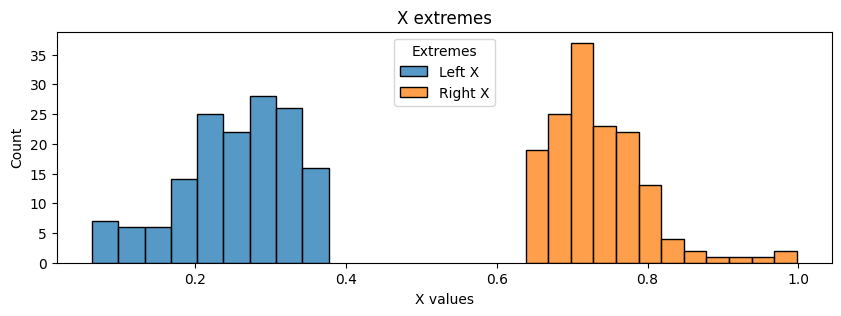

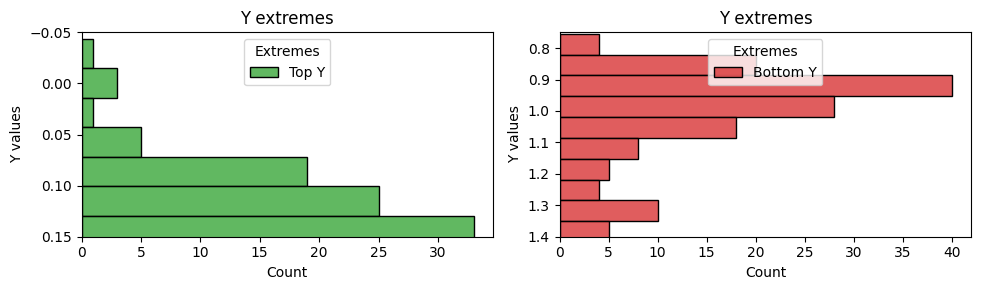

In [46]:
# side by side
fig, axs = plt.subplots(figsize=(10, 3));
sns.histplot(analysis_info['raw_landmark_extremes_overall_left_x'])
sns.histplot(analysis_info['raw_landmark_extremes_overall_right_x'])
plt.title('X extremes')
plt.xlabel('X values')
plt.legend(title = 'Extremes', labels = ['Left X', 'Right X'], loc = 'upper center')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3));
sns.histplot(data = analysis_info, y = 'raw_landmark_extremes_overall_top_y', ax = axs[0], color = 'tab:green')
axs[0].set_title('Y extremes')
axs[0].set_ylabel('Y values')
axs[0].legend(title = 'Extremes', labels = ['Top Y'], loc = 'upper center')
axs[0].set_ylim(0.15, -0.05)
sns.histplot(data = analysis_info, y = 'raw_landmark_extremes_overall_bottom_y', ax = axs[1], color = 'tab:red')
axs[1].set_title('Y extremes')
axs[1].set_ylabel('Y values')
axs[1].set_ylim(1.4, .75)
axs[1].legend(title = 'Extremes', labels = ['Bottom Y'], loc = 'upper center')
plt.tight_layout()

##### Preprocessed Landmarks

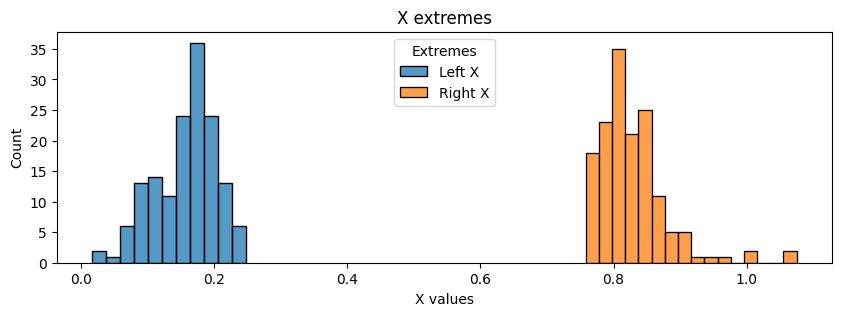

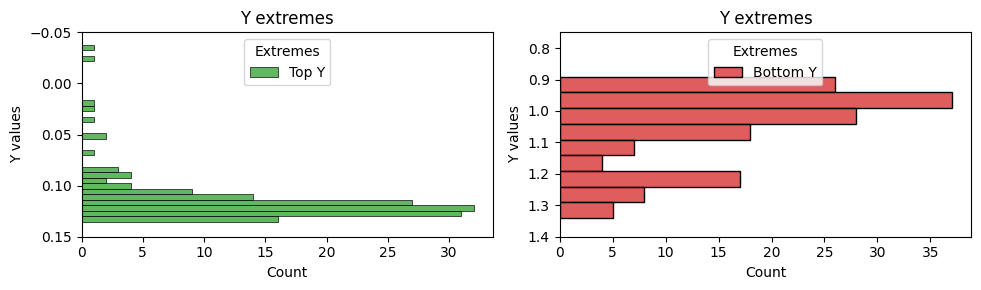

In [43]:
# side by side
fig, axs = plt.subplots(figsize=(10, 3));
sns.histplot(analysis_info['trimmed_landmark_extremes_overall_left_x'])
sns.histplot(analysis_info['trimmed_landmark_extremes_overall_right_x'])
plt.title('X extremes')
plt.xlabel('X values')
plt.legend(title = 'Extremes', labels = ['Left X', 'Right X'], loc = 'upper center')
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(10, 3));
sns.histplot(data = analysis_info, y = 'trimmed_landmark_extremes_overall_top_y', ax = axs[0], color = 'tab:green')
axs[0].set_title('Y extremes')
axs[0].set_ylabel('Y values')
axs[0].legend(title = 'Extremes', labels = ['Top Y'], loc = 'upper center')
axs[0].set_ylim(0.15, -0.05)
sns.histplot(data = analysis_info, y = 'trimmed_landmark_extremes_overall_bottom_y', ax = axs[1], color = 'tab:red')
axs[1].set_title('Y extremes')
axs[1].set_ylabel('Y values')
axs[1].set_ylim(1.4, .75)
axs[1].legend(title = 'Extremes', labels = ['Bottom Y'], loc = 'upper center')
plt.tight_layout()

##### Raw Landmarks (By Data Source)

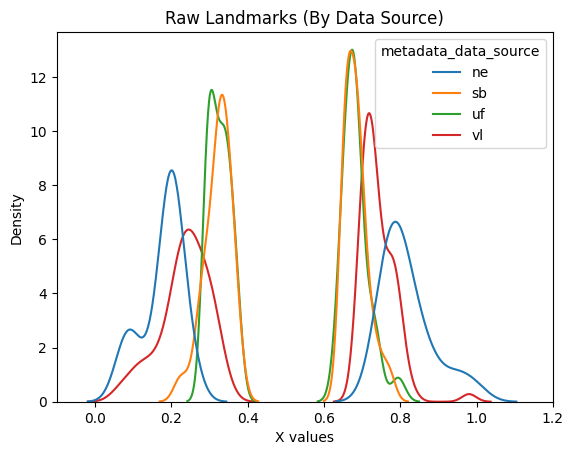

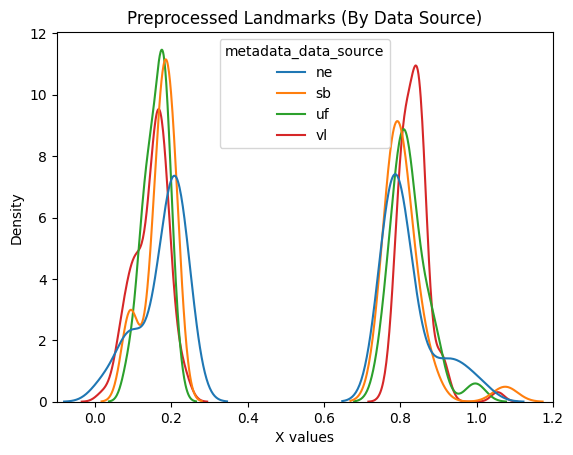

In [55]:
sns.kdeplot(data = analysis_info, x = 'raw_landmark_extremes_overall_left_x', hue = 'metadata_data_source', common_norm=False)
sns.kdeplot(data = analysis_info, x = 'raw_landmark_extremes_overall_right_x', hue = 'metadata_data_source', common_norm=False)
plt.title('Raw Landmarks (By Data Source)')
plt.xlabel('X values')
plt.xlim(-0.1, 1.2)
plt.show()

sns.kdeplot(data = analysis_info, x = 'trimmed_landmark_extremes_overall_left_x', hue = 'metadata_data_source', common_norm=False)
sns.kdeplot(data = analysis_info, x = 'trimmed_landmark_extremes_overall_right_x', hue = 'metadata_data_source', common_norm=False)
plt.title('Preprocessed Landmarks (By Data Source)')
plt.xlabel('X values')
plt.xlim(-0.1, 1.2)
plt.show()

##### Preprocessed Landmarks (By Data Source)

In [195]:
left_x_outliers = get_outlier_df(analysis_info, 'trimmed_landmark_extremes_overall_left_x')
right_x_outliers = get_outlier_df(analysis_info, 'trimmed_landmark_extremes_overall_right_x')
top_y_outliers = get_outlier_df(analysis_info, 'trimmed_landmark_extremes_overall_top_y')
bottom_y_outliers = get_outlier_df(analysis_info, 'trimmed_landmark_extremes_overall_bottom_y')

Text(0.5, 1.05, 'X extremes for preprocessed landmarks')

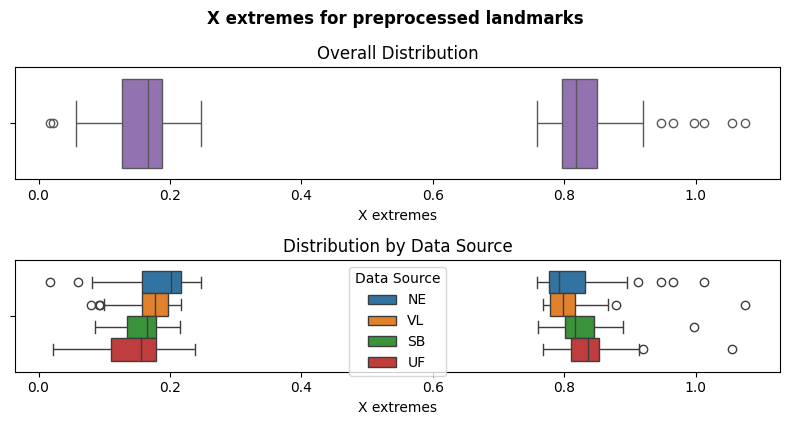

In [165]:
# boxplot
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))

sns.boxplot(data=analysis_info, x='trimmed_landmark_extremes_overall_left_x', color="tab:purple", ax=ax1)
sns.boxplot(data=analysis_info, x='trimmed_landmark_extremes_overall_right_x', color="tab:purple", ax=ax1)
ax1.set_title("Overall Distribution")
ax1.set_xlabel("X extremes")

sns.boxplot(data=analysis_info, x='trimmed_landmark_extremes_overall_left_x', hue='metadata_data_source', ax=ax2)
sns.boxplot(data=analysis_info, x='trimmed_landmark_extremes_overall_right_x', hue='metadata_data_source', ax=ax2)
ax2.set_title("Distribution by Data Source")
ax2.legend(title = 'Data Source', labels = ['NE', 'VL', 'SB', 'UF'], loc = 'upper center')
ax2.set_xlabel("X extremes")


plt.tight_layout()
plt.suptitle("X extremes for preprocessed landmarks", fontweight = "bold", y = 1.05)

In [205]:
pd.concat([left_x_outliers, right_x_outliers]).sort_values(['metadata_filename'])

,metadata_filename,metadata_data_source,trimmed_landmark_extremes_overall_left_x,col,trimmed_landmark_extremes_overall_right_x
6,animal_ne_1.mp4,ne,0.016887,trimmed_landmark_extremes_overall_left_x_outliers,NaN
6,animal_ne_1.mp4,ne,NaN,trimmed_landmark_extremes_overall_right_x_outl...,0.964727
12,aniversário_ne_1.mp4,ne,0.059389,trimmed_landmark_extremes_overall_left_x_outliers,NaN
12,aniversário_ne_1.mp4,ne,NaN,trimmed_landmark_extremes_overall_right_x_outl...,0.947182
13,aniversário_sb_2.mp4,sb,0.079746,trimmed_landmark_extremes_overall_left_x_outliers,NaN
36,bebê_ne_1.mp4,ne,NaN,trimmed_landmark_extremes_overall_right_x_outl...,0.912215
37,bebê_sb_2.mp4,sb,NaN,trimmed_landmark_extremes_overall_right_x_outl...,0.878244
41,bebê_vl_6.mp4,vl,NaN,trimmed_landmark_extremes_overall_right_x_outl...,0.919109
43,cabeça_sb_2.mp4,sb,0.093766,trimmed_landmark_extremes_overall_left_x_outliers,NaN
114,jovem_ne_1.mp4,ne,NaN,trimmed_landmark_extremes_overall_right_x_outl...,1.012666


Text(0.5, 1.05, 'Y extremes for preprocessed landmarks')

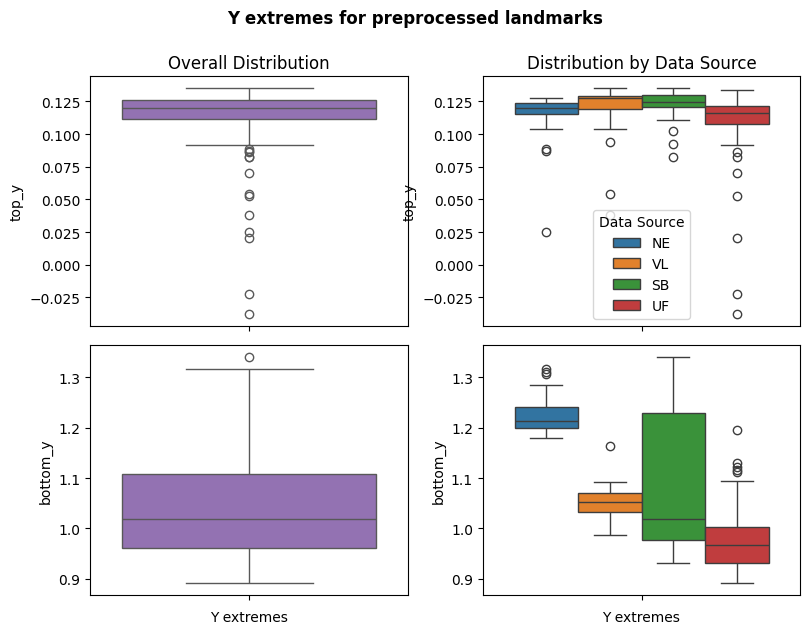

In [197]:
# boxplot
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(8, 6))

sns.boxplot(data=analysis_info, y='trimmed_landmark_extremes_overall_top_y', color="tab:purple", ax=ax1[0])
sns.boxplot(data=analysis_info, y='trimmed_landmark_extremes_overall_bottom_y', color="tab:purple", ax=ax2[0])
ax1[0].set_title("Overall Distribution")
ax2[0].set_xlabel("Y extremes")
ax1[0].set_ylabel('top_y')
ax2[0].set_ylabel('bottom_y')

sns.boxplot(data=analysis_info, y='trimmed_landmark_extremes_overall_top_y', hue='metadata_data_source', ax=ax1[1])
sns.boxplot(data=analysis_info, y='trimmed_landmark_extremes_overall_bottom_y', hue='metadata_data_source', ax=ax2[1])
ax1[1].set_title("Distribution by Data Source")
ax1[1].legend(title = 'Data Source', labels = ['NE', 'VL', 'SB', 'UF'], loc = 'lower center')
ax2[1].legend().remove()
ax2[1].set_xlabel("Y extremes")
ax1[1].set_ylabel('top_y')
ax2[1].set_ylabel('bottom_y')



plt.tight_layout()
plt.suptitle("Y extremes for preprocessed landmarks", fontweight = "bold", y = 1.05)

In [206]:
top_y_outliers

,metadata_filename,metadata_data_source,trimmed_landmark_extremes_overall_top_y,col
42,cabeça_ne_1.mp4,ne,0.025160,trimmed_landmark_extremes_overall_top_y_outliers
102,garganta_ne_1.mp4,ne,0.088840,trimmed_landmark_extremes_overall_top_y_outliers
144,vagina_ne_1.mp4,ne,0.087018,trimmed_landmark_extremes_overall_top_y_outliers
43,cabeça_sb_2.mp4,sb,0.054183,trimmed_landmark_extremes_overall_top_y_outliers
103,garganta_sb_2.mp4,sb,0.094060,trimmed_landmark_extremes_overall_top_y_outliers
145,vagina_sb_2.mp4,sb,0.037783,trimmed_landmark_extremes_overall_top_y_outliers
50,café_uf_3.mp4,uf,0.092028,trimmed_landmark_extremes_overall_top_y_outliers
104,garganta_uf_3.mp4,uf,0.102645,trimmed_landmark_extremes_overall_top_y_outliers
146,vagina_uf_3.mp4,uf,0.082567,trimmed_landmark_extremes_overall_top_y_outliers
45,cabeça_vl_4.mp4,vl,0.085943,trimmed_landmark_extremes_overall_top_y_outliers


In [207]:
bottom_y_outliers

,metadata_filename,metadata_data_source,trimmed_landmark_extremes_overall_bottom_y,col
108,homem_ne_1.mp4,ne,1.311212,trimmed_landmark_extremes_overall_bottom_y_out...
132,sopa_ne_1.mp4,ne,1.306075,trimmed_landmark_extremes_overall_bottom_y_out...
144,vagina_ne_1.mp4,ne,1.317648,trimmed_landmark_extremes_overall_bottom_y_out...
109,homem_sb_2.mp4,sb,1.164077,trimmed_landmark_extremes_overall_bottom_y_out...
71,cebola_vl_6.mp4,vl,1.111714,trimmed_landmark_extremes_overall_bottom_y_out...
87,crescer_vl_4.mp4,vl,1.130205,trimmed_landmark_extremes_overall_bottom_y_out...
101,filho_vl_6.mp4,vl,1.121507,trimmed_landmark_extremes_overall_bottom_y_out...
113,homem_vl_6.mp4,vl,1.196046,trimmed_landmark_extremes_overall_bottom_y_out...
147,vagina_vl_4.mp4,vl,1.116238,trimmed_landmark_extremes_overall_bottom_y_out...


## Check the None frames

*Note*
**When landmarks are None:**
- `pose_landmarks`: None if no pose detected in frame
- `face_landmarks`: None if no face detected
- `left_hand_landmarks`/`right_hand_landmarks`: None if hand not detected

**Key points about None values:**
- Landmarks are never individually None - entire group for a frame is either None or present
- If group is present for a frame, all landmarks in that group are included:
  - Pose: 33 landmarks
  - Face: 468 landmarks  
  - Each hand: 21 landmarks
- Only pose landmarks have visibility scores to detect unreliable points

### Distribution of None landmarks

(0.0, 50.0)

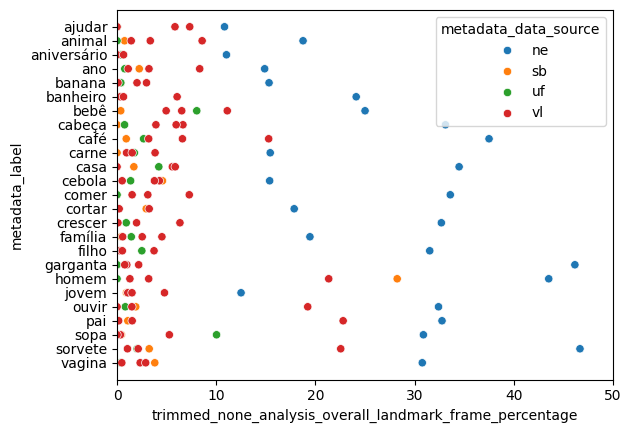

In [50]:
sns.scatterplot(data=analysis_info, x='trimmed_none_analysis_overall_landmark_frame_percentage', y='metadata_label', hue='metadata_data_source')
plt.xlim(0, 50)


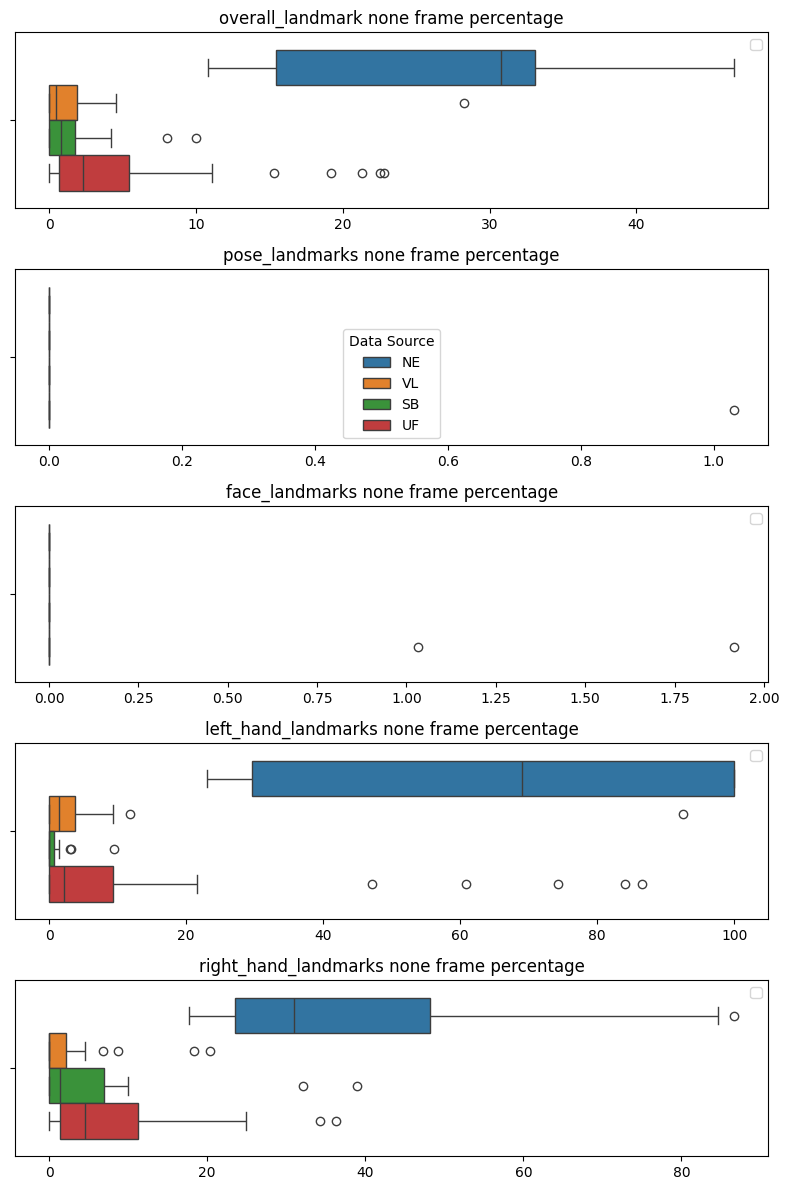

In [32]:
fig, axs = plt.subplots(5, 1, figsize=(8, 12));
landmark_types = ['overall_landmark', 'pose_landmarks', 'face_landmarks', 'left_hand_landmarks', 'right_hand_landmarks']
for ax, landmark_type in zip(axs, landmark_types):
    sns.boxplot(data=analysis_info, x=f'trimmed_none_analysis_{landmark_type}_frame_percentage', hue='metadata_data_source', ax=ax)
    ax.legend('')
    ax.set_title(f'{landmark_type} none frame percentage')
    ax.set_xlabel('')
axs[1].legend(title = 'Data Source', labels = ['NE', 'VL', 'SB', 'UF'], loc = 'lower center')
plt.tight_layout()

In [ ]:
get_outlier_df_and_minmax_df

In [51]:
pose_outliers  = get_outlier_df(analysis_info, 'trimmed_none_analysis_pose_landmarks_frame_percentage')
face_outliers = get_outlier_df(analysis_info, 'trimmed_none_analysis_face_landmarks_frame_percentage')
left_outliers, left_minmax = get_outlier_df_and_minmax_df(analysis_info, 'trimmed_none_analysis_left_hand_landmarks_frame_percentage')
right_outliers, right_minmax = get_outlier_df_and_minmax_df(analysis_info, 'trimmed_none_analysis_right_hand_landmarks_frame_percentage')

In [52]:
pose_outliers

,metadata_filename,metadata_data_source,trimmed_none_analysis_pose_landmarks_frame_percentage,col
9,animal_vl_4.mp4,vl,1.030928,trimmed_none_analysis_pose_landmarks_frame_per...


In [57]:
face_outliers

,metadata_filename,metadata_data_source,trimmed_none_analysis_face_landmarks_frame_percentage,col
9,animal_vl_4.mp4,vl,1.030928,trimmed_none_analysis_face_landmarks_frame_per...
149,vagina_vl_6.mp4,vl,1.916933,trimmed_none_analysis_face_landmarks_frame_per...


In [31]:
analysis_info.iloc[9].to_dict()

{'metadata_filename': 'animal_vl_4.mp4',
 'metadata_label': 'animal',
 'metadata_data_source': 'vl',
 'metadata_sign_id': 0,
 'metadata_signer_number': 1,
 'metadata_frame_count': 116,
 'metadata_fps': 23.976023976023978,
 'metadata_duration_sec': 4.838166666666666,
 'metadata_width': 1920,
 'metadata_height': 1080,
 'metadata_needs_flip': False,
 'metadata_cleaned': True,
 'metadata_preprocessing_version': 'v3',
 'metadata_face_width_aim': 0.155,
 'metadata_shoulders_width_aim': 0.35,
 'metadata_face_midpoint_to_shoulders_height_aim': 0.275,
 'metadata_shoulders_y_aim': 0.52,
 'metadata_use_statistic': 'mean',
 'metadata_use_stationary_frames': True,
 'metadata_skip_stationary_frames': False,
 'metadata_start_frame': 0,
 'metadata_end_frame': 96,
 'metadata_start_time': 0.0,
 'metadata_end_time': 4.004,
 'metadata_start_percent': 0.0,
 'metadata_end_percent': 0.8275862068965517,
 'metadata_new_frame_count': 96,
 'metadata_new_duration_sec': 4.004,
 'metadata_new_duration_percent': 0.8

In [59]:
analysis_info[analysis_info['metadata_start_frame'] == 0]

,metadata_filename,metadata_label,metadata_data_source,metadata_sign_id,metadata_signer_number,metadata_frame_count,metadata_fps,metadata_duration_sec,metadata_width,metadata_height,...,interpolated_none_analysis_right_hand_landmarks_first_valid,interpolated_none_analysis_right_hand_landmarks_last_valid,interpolated_none_analysis_right_hand_landmarks_valid_range_total_frames,interpolated_none_analysis_right_hand_landmarks_valid_range_none_frames,interpolated_none_analysis_right_hand_landmarks_valid_range_frame_percentage,interpolated_none_analysis_right_hand_landmarks_valid_range_none_details,interpolated_interpolation_info_left_hand_landmarks_total_interpolated_frames,interpolated_interpolation_info_left_hand_landmarks_interpolated_frame_indices,interpolated_interpolation_info_right_hand_landmarks_total_interpolated_frames,interpolated_interpolation_info_right_hand_landmarks_interpolated_frame_indices
4,ajudar_vl_5.mp4,ajudar,vl,0,2,108,29.970000,3.603604,1920,1080,...,0,106,107,10,9.345794,"[4, 5, 6, 7, 8, 9, 10, 11, 12, 13]",0,[],2,"[62, 99]"
5,ajudar_vl_6.mp4,ajudar,vl,0,3,310,60.000000,5.166667,1920,1080,...,0,271,272,0,0.000000,[],0,[],0,[]
9,animal_vl_4.mp4,animal,vl,0,1,116,23.976024,4.838167,1920,1080,...,1,96,96,6,6.250000,"[12, 13, 14, 27, 28, 29]",2,"[8, 84]",1,[89]
17,aniversário_vl_6.mp4,aniversário,vl,0,3,269,59.940060,4.487817,1920,1080,...,1,265,265,0,0.000000,[],1,[9],2,"[257, 263]"
19,ano_sb_2.mp4,ano,sb,1,1,70,29.970030,2.335667,1280,720,...,0,66,67,2,2.985075,"[20, 21]",0,[],1,[33]
33,banheiro_vl_4.mp4,banheiro,vl,0,1,300,59.940060,5.005000,1920,1080,...,0,286,287,0,0.000000,[],0,[],0,[]
34,banheiro_vl_5.mp4,banheiro,vl,0,2,129,29.970000,4.304304,1920,1080,...,0,127,128,29,22.656250,"[6, 7, 33, 34, 35, 36, 37, 46, 47, 48, 49, 50,...",0,[],2,"[74, 116]"
35,banheiro_vl_6.mp4,banheiro,vl,0,3,354,59.940060,5.905900,1280,720,...,0,306,307,8,2.605863,"[288, 289, 290, 291, 292, 293, 294, 295]",0,[],0,[]
41,bebê_vl_6.mp4,bebê,vl,0,3,331,59.940060,5.522183,1920,1080,...,5,321,317,60,18.927445,"[12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 58, 5...",2,"[53, 196]",15,"[56, 68, 70, 85, 92, 133, 135, 184, 194, 205, ..."
46,cabeça_vl_5.mp4,cabeça,vl,0,2,176,29.970030,5.872533,1920,1080,...,2,137,136,13,9.558824,"[6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 129, 130,...",1,[123],0,[]


In [56]:
pd.concat([pose_outliers, face_outliers, left_outliers, right_outliers]).groupby('metadata_filename').max().drop('col', axis=1)

,metadata_data_source,trimmed_none_analysis_pose_landmarks_frame_percentage,trimmed_none_analysis_face_landmarks_frame_percentage,trimmed_none_analysis_left_hand_landmarks_frame_percentage,trimmed_none_analysis_right_hand_landmarks_frame_percentage
metadata_filename,,,,,
animal_vl_4.mp4,vl,1.030928,1.030928,NaN,NaN
animal_vl_5.mp4,vl,NaN,NaN,NaN,34.306569
ano_uf_3.mp4,uf,NaN,NaN,3.125000,NaN
bebê_uf_3.mp4,uf,NaN,NaN,NaN,32.142857
bebê_vl_5.mp4,vl,NaN,NaN,NaN,36.257310
cabeça_uf_3.mp4,uf,NaN,NaN,3.030303,NaN
café_vl_4.mp4,vl,NaN,NaN,47.133758,NaN
casa_sb_2.mp4,sb,NaN,NaN,NaN,6.779661
casa_uf_3.mp4,uf,NaN,NaN,9.473684,NaN


#### By type

#### By source

#### Before and after preprocessing

#### How many were filled using interpolation

## Checking individual cases - Landmarks

In [10]:
i = 85
metadata_row = metadata.iloc[i].copy()
raw_landmarks_path = path_to_root + f'/data/interim/RawPoseLandmarks/{pose_version}/{metadata_row["filename"].replace(".mp4", ".npy")}'
preprocessed_landmarks_path = path_to_root + f'/data/preprocessed/landmarks/{preprocess_version}/{metadata_row["filename"].replace(".mp4", ".npy")}'
video_path = path_to_root + f'/data/interim/RawCleanVideos/{metadata_row["filename"]}'
raw_landmarks = np.load(raw_landmarks_path, allow_pickle=True)
preprocessed_landmarks = np.load(preprocessed_landmarks_path, allow_pickle=True)
metadata_row

filename                             crescer_sb_2.mp4
label                                         crescer
data_source                                        sb
original_fps                                 29.97003
original_frame_count                               74
original_duration_sec                        2.469133
start_frame                                         2
end_frame                                          66
processed_frame_count                              65
processed_duration_sec                       2.168833
preprocess_version                                 v3
face_width                                   0.083436
shoulders_width                              0.194761
face_midpoint_to_shoulders_height            0.213649
left_hand_interpolated_frames                       0
right_hand_interpolated_frames                      0
original_left_hand_none_frames                      0
original_right_hand_none_frames                     0
final_left_hand_none_frames 

In [25]:
analysis_info.iloc[85]

metadata_filename                                                               crescer_sb_2.mp4
metadata_label                                                                           crescer
metadata_data_source                                                                          sb
metadata_sign_id                                                                               1
metadata_signer_number                                                                         1
                                                                                      ...       
interpolated_none_analysis_right_hand_landmarks_last_valid                                  64.0
interpolated_none_analysis_right_hand_landmarks_valid_range_total_frames                    65.0
interpolated_none_analysis_right_hand_landmarks_valid_range_none_frames                      0.0
interpolated_none_analysis_right_hand_landmarks_valid_range_frame_percentage                 0.0
interpolated_none_analysis_rig

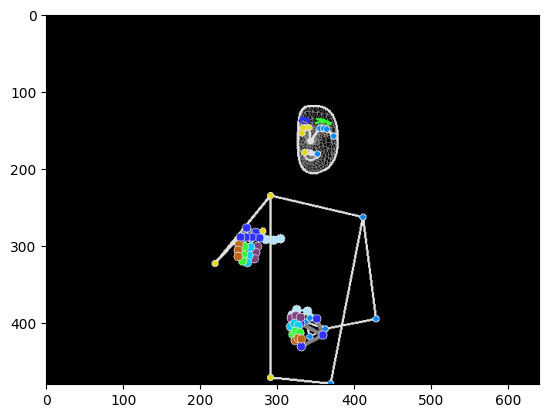

In [15]:
plot = viz.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), raw_landmarks[20])
plt.imshow(plot);

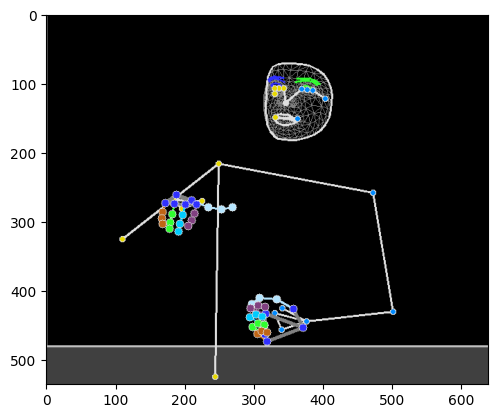

In [16]:
plot = viz.draw_landmarks_on_frame(np.zeros((480,640,3), dtype=np.uint8), preprocessed_landmarks[20])
plt.imshow(plot);